# 📋 Nota Importante sobre el ETL

Este notebook incluye su **propio proceso ETL integrado** que:
- ✅ Carga archivos CSV individuales desde la carpeta `csv/` (2015-2019)
- ✅ Normaliza los nombres de columnas entre diferentes años
- ✅ Limpia valores nulos automáticamente
- ✅ Selecciona las features necesarias para el modelado

**No es necesario ejecutar ningún script ETL externo**. Todo el proceso está automatizado en la sección 1 del notebook.

---

# 🤖 Modelos de Regresión - World Happiness Report

Este notebook implementa **3 modelos de Machine Learning** para predecir el Happiness Score utilizando datos de 2015-2019.

## Modelos:
1. **Regresión Lineal Múltiple**: Modelo interpretable que captura relaciones lineales
2. **Random Forest Regressor**: Ensemble de árboles de decisión, robusto a outliers
3. **Regresión Lineal Múltiple con Escalado (StandardScaler)**: Modelo con features estandarizadas para mejor interpretabilidad

## Métricas de Evaluación:
- **R² (Coefficient of Determination)**: Proporción de varianza explicada
- **MAE (Mean Absolute Error)**: Error promedio absoluto
- **RMSE (Root Mean Squared Error)**: Raíz del error cuadrático medio
- **MAPE (Mean Absolute Percentage Error)**: Error porcentual promedio

## División de Datos:
- **70% Entrenamiento** - **30% Prueba**

In [4]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

---
## 📊 1. Carga y Preparación de Datos

In [5]:
# =========================================================================
# ETL PROCESS: Extract → Transform → Load
# =========================================================================
import os
import glob

def extract_csv_files():
    """
    [ETL - EXTRACT] Extrae datos desde archivos CSV individuales (2015-2019).
    
    Returns:
        DataFrame combinado con todos los años
    """
    # Obtener ruta a la carpeta csv
    notebook_dir = os.getcwd()
    if 'model_regresion' in notebook_dir:
        project_root = os.path.dirname(notebook_dir)
    else:
        project_root = notebook_dir
    
    csv_dir = os.path.join(project_root, 'csv')
    
    print("📥 [EXTRACT] Cargando archivos CSV individuales...")
    
    # Buscar todos los CSV de años
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))
    csv_files = [f for f in csv_files if any(year in os.path.basename(f) for year in ['2015', '2016', '2017', '2018', '2019'])]
    
    if not csv_files:
        raise FileNotFoundError(f"❌ No se encontraron archivos CSV en {csv_dir}")
    
    # Mapeo de columnas por año
    column_mappings = {
        2015: {
            'Country': 'Country',
            'Happiness Score': 'Score',
            'Economy (GDP per Capita)': 'GDP per capita',
            'Family': 'Social support',
            'Health (Life Expectancy)': 'Healthy life expectancy',
            'Freedom': 'Freedom to make life choices',
            'Trust (Government Corruption)': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2016: {
            'Country': 'Country',
            'Happiness Score': 'Score',
            'Economy (GDP per Capita)': 'GDP per capita',
            'Family': 'Social support',
            'Health (Life Expectancy)': 'Healthy life expectancy',
            'Freedom': 'Freedom to make life choices',
            'Trust (Government Corruption)': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2017: {
            'Country': 'Country',
            'Happiness.Score': 'Score',
            'Economy..GDP.per.Capita.': 'GDP per capita',
            'Family': 'Social support',
            'Health..Life.Expectancy.': 'Healthy life expectancy',
            'Freedom': 'Freedom to make life choices',
            'Trust..Government.Corruption.': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2018: {
            'Country or region': 'Country',
            'Score': 'Score',
            'GDP per capita': 'GDP per capita',
            'Social support': 'Social support',
            'Healthy life expectancy': 'Healthy life expectancy',
            'Freedom to make life choices': 'Freedom to make life choices',
            'Perceptions of corruption': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2019: {
            'Country or region': 'Country',
            'Score': 'Score',
            'GDP per capita': 'GDP per capita',
            'Social support': 'Social support',
            'Healthy life expectancy': 'Healthy life expectancy',
            'Freedom to make life choices': 'Freedom to make life choices',
            'Perceptions of corruption': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        }
    }
    
    dfs = []
    for file in sorted(csv_files):
        year = int(os.path.basename(file).split('.')[0])
        df = pd.read_csv(file)
        
        # Aplicar mapeo de columnas específico del año
        if year in column_mappings:
            mapping = column_mappings[year]
            # Seleccionar y renombrar solo las columnas que existen
            cols_to_select = {old: new for old, new in mapping.items() if old in df.columns}
            df = df[list(cols_to_select.keys())].rename(columns=cols_to_select)
        
        df['Year'] = year
        dfs.append(df)
        print(f"   ✅ {os.path.basename(file)}: {len(df)} registros - {len(df.columns)} columnas")
    
    df_combined = pd.concat(dfs, ignore_index=True)
    print(f"📊 [EXTRACT] Total extraído: {len(df_combined)} registros (2015-2019)")
    
    return df_combined


def transform_clean_nulls(df):
    """
    [ETL - TRANSFORM] Elimina registros con valores nulos en columnas críticas.
    
    Args:
        df: DataFrame combinado
        
    Returns:
        DataFrame limpio
    """
    print("🔄 [TRANSFORM] Limpiando valores nulos...")
    
    initial_count = len(df)
    
    # Columnas críticas que no deben tener nulos
    critical_columns = [
        'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'
    ]
    
    df_clean = df.dropna(subset=critical_columns)
    removed_count = initial_count - len(df_clean)
    
    print(f"   ✅ Registros limpios: {len(df_clean)}")
    print(f"   ❌ Registros eliminados: {removed_count}")
    
    return df_clean


def transform_select_features(df):
    """
    [ETL - TRANSFORM] Selecciona las columnas necesarias para el modelo.
    
    Args:
        df: DataFrame con columnas normalizadas
        
    Returns:
        DataFrame con columnas seleccionadas
    """
    print("🔄 [TRANSFORM] Seleccionando features para el modelo...")
    
    required_columns = [
        'Country', 'Year', 'Score',
        'GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'
    ]
    
    # Seleccionar solo columnas que existen
    available_cols = [col for col in required_columns if col in df.columns]
    df_selected = df[available_cols].copy()
    
    print(f"   ✅ {len(available_cols)} columnas seleccionadas")
    
    return df_selected


# =========================================================================
# EJECUTAR PIPELINE ETL
# =========================================================================

print("="*80)
print("🔄 INICIANDO PIPELINE ETL - CARGA DE DATOS")
print("="*80)

# EXTRACT: Cargar archivos CSV individuales con normalización de columnas
df = extract_csv_files()

# TRANSFORM: Limpiar nulos y seleccionar columnas
df = transform_clean_nulls(df)
df = transform_select_features(df)

print("="*80)
print("✅ PIPELINE ETL COMPLETADO")
print("="*80)

# Mostrar información del DataFrame cargado
print(f"\n✅ Datos cargados exitosamente")
print(f"\nDimensiones totales: {df.shape}")
print(f"\nRegistros por año:")
print(df['Year'].value_counts().sort_index())
print(f"\nColumnas disponibles:")
print(df.columns.tolist())
print(f"\nPrimeras filas:")
display(df.head(10))

🔄 INICIANDO PIPELINE ETL - CARGA DE DATOS
📥 [EXTRACT] Cargando archivos CSV individuales...
   ✅ 2015.csv: 158 registros - 9 columnas
   ✅ 2016.csv: 157 registros - 9 columnas
   ✅ 2017.csv: 155 registros - 9 columnas
   ✅ 2018.csv: 156 registros - 9 columnas
   ✅ 2019.csv: 156 registros - 9 columnas
📊 [EXTRACT] Total extraído: 782 registros (2015-2019)
🔄 [TRANSFORM] Limpiando valores nulos...
   ✅ Registros limpios: 781
   ❌ Registros eliminados: 1
🔄 [TRANSFORM] Seleccionando features para el modelo...
   ✅ 9 columnas seleccionadas
✅ PIPELINE ETL COMPLETADO

✅ Datos cargados exitosamente

Dimensiones totales: (781, 9)

Registros por año:
Year
2015    158
2016    157
2017    155
2018    155
2019    156
Name: count, dtype: int64

Columnas disponibles:
['Country', 'Year', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

Primeras filas:


,Country,Year,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Switzerland,2015,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,Iceland,2015,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,Denmark,2015,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,Norway,2015,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,Canada,2015,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957
5,Finland,2015,7.406,1.29025,1.31826,0.88911,0.64169,0.23351,0.41372
6,Netherlands,2015,7.378,1.32944,1.28017,0.89284,0.61576,0.47610,0.31814
7,Sweden,2015,7.364,1.33171,1.28907,0.91087,0.65980,0.36262,0.43844
8,New Zealand,2015,7.286,1.25018,1.31967,0.90837,0.63938,0.47501,0.42922
9,Australia,2015,7.284,1.33358,1.30923,0.93156,0.65124,0.43562,0.35637


In [6]:
# Verificar valores nulos en el DataFrame procesado
print("\n" + "="*80)
print("VERIFICACIÓN DE VALORES NULOS")
print("="*80)
print("\nValores nulos por columna:")
print(df.isnull().sum())
print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")

if df.isnull().sum().sum() == 0:
    print("\n✅ No hay valores nulos - El proceso ETL limpió correctamente los datos")


VERIFICACIÓN DE VALORES NULOS

Valores nulos por columna:
Country                         0
Year                            0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

Total de valores nulos: 0

✅ No hay valores nulos - El proceso ETL limpió correctamente los datos


In [7]:
# Preparar datos para modelado
# Variable objetivo (y): Score
# Variables predictoras (X): GDP per capita, Social support, etc.

# Seleccionar features y target
feature_columns = ['GDP per capita', 'Social support', 'Healthy life expectancy', 
                   'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

# Verificar y limpiar datos nulos antes de dividir
print("Valores nulos antes de limpiar:")
print(df[feature_columns + ['Score']].isnull().sum())

# Eliminar filas con valores nulos en las columnas importantes
df_limpio = df.dropna(subset=feature_columns + ['Score'])

print(f"\nRegistros después de limpiar: {len(df_limpio)} (eliminados: {len(df) - len(df_limpio)})")

X = df_limpio[feature_columns]
y = df_limpio['Score']


print(f"\nVariables predictoras (X): {X.shape}")
print(f"Variable objetivo (y): {y.shape}")
print(f"\nDistribución por año en datos limpios:")
print(df_limpio['Year'].value_counts().sort_index())
print(f"\nFeatures utilizadas:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

Valores nulos antes de limpiar:
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
Score                           0
dtype: int64

Registros después de limpiar: 781 (eliminados: 0)

Variables predictoras (X): (781, 6)
Variable objetivo (y): (781,)

Distribución por año en datos limpios:
Year
2015    158
2016    157
2017    155
2018    155
2019    156
Name: count, dtype: int64

Features utilizadas:
  1. GDP per capita
  2. Social support
  3. Healthy life expectancy
  4. Freedom to make life choices
  5. Generosity
  6. Perceptions of corruption


In [8]:
# Estadísticas de las variables
print("\nEstadísticas de las variables predictoras:")
X.describe()


Estadísticas de las variables predictoras:


,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,0.914537,1.078780,0.612342,0.411254,0.218618,0.125436
std,0.405403,0.329581,0.248459,0.152911,0.122394,0.105816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.605000,0.870210,0.440060,0.310480,0.130000,0.054000
50%,0.982000,1.125000,0.647239,0.431000,0.202000,0.091000
75%,1.233748,1.328000,0.808000,0.531000,0.279060,0.156030
max,1.870766,1.644000,1.141000,0.724000,0.838075,0.551910


In [9]:
# Dividir datos en conjunto de entrenamiento y prueba (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("="*80)
print("DIVISIÓN DE DATOS (70% ENTRENAMIENTO - 30% PRUEBA)")
print("="*80)
print(f"\nConjunto de entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nConjunto de prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"\nPorcentaje de datos de entrenamiento: {len(X_train)/len(X)*100:.1f}%")
print(f"Porcentaje de datos de prueba: {len(X_test)/len(X)*100:.1f}%")

DIVISIÓN DE DATOS (70% ENTRENAMIENTO - 30% PRUEBA)

Conjunto de entrenamiento:
  X_train: (546, 6)
  y_train: (546,)

Conjunto de prueba:
  X_test: (235, 6)
  y_test: (235,)

Porcentaje de datos de entrenamiento: 69.9%
Porcentaje de datos de prueba: 30.1%


---
## 🎯 2. Funciones de Evaluación

In [10]:
def calcular_metricas(y_true, y_pred, nombre_modelo):
    """
    Calcula métricas de evaluación para modelos de regresión
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{'='*80}")
    print(f"MÉTRICAS DE EVALUACIÓN - {nombre_modelo}")
    print(f"{'='*80}")
    print(f"R² (Coefficient of Determination):    {r2:.4f}")
    print(f"MAE (Mean Absolute Error):            {mae:.4f}")
    print(f"MSE (Mean Squared Error):             {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error):       {rmse:.4f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    return {
        'R2': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

def graficar_predicciones(y_true, y_pred, nombre_modelo):
    """
    Crea visualizaciones de las predicciones vs valores reales
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Predicciones vs Valores Reales
    axes[0].scatter(y_true, y_pred, alpha=0.6, s=100, edgecolors='black', linewidth=1)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=3, label='Predicción Perfecta')
    axes[0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predicciones', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{nombre_modelo}\nPredicciones vs Valores Reales', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Residuales
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, s=100, edgecolors='black', linewidth=1)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=3, label='Residual = 0')
    axes[1].set_xlabel('Predicciones', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Residuales', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{nombre_modelo}\nGráfico de Residuales', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Funciones de evaluación definidas")

Funciones de evaluación definidas


---
## 📈 3. Modelo: Regresión Lineal Múltiple

In [11]:
# Crear y entrenar el modelo
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

print("\n✅ Modelo de Regresión Lineal entrenado exitosamente")
print(f"\nIntercept (β₀): {modelo_lr.intercept_:.4f}")


✅ Modelo de Regresión Lineal entrenado exitosamente

Intercept (β₀): 2.1799



COEFICIENTES DEL MODELO:
                     Feature  Coeficiente
Freedom to make life choices     1.614804
              GDP per capita     1.065962
     Healthy life expectancy     1.060623
   Perceptions of corruption     0.966367
              Social support     0.630179
                  Generosity     0.561096

Intercept (β₀): 2.1799


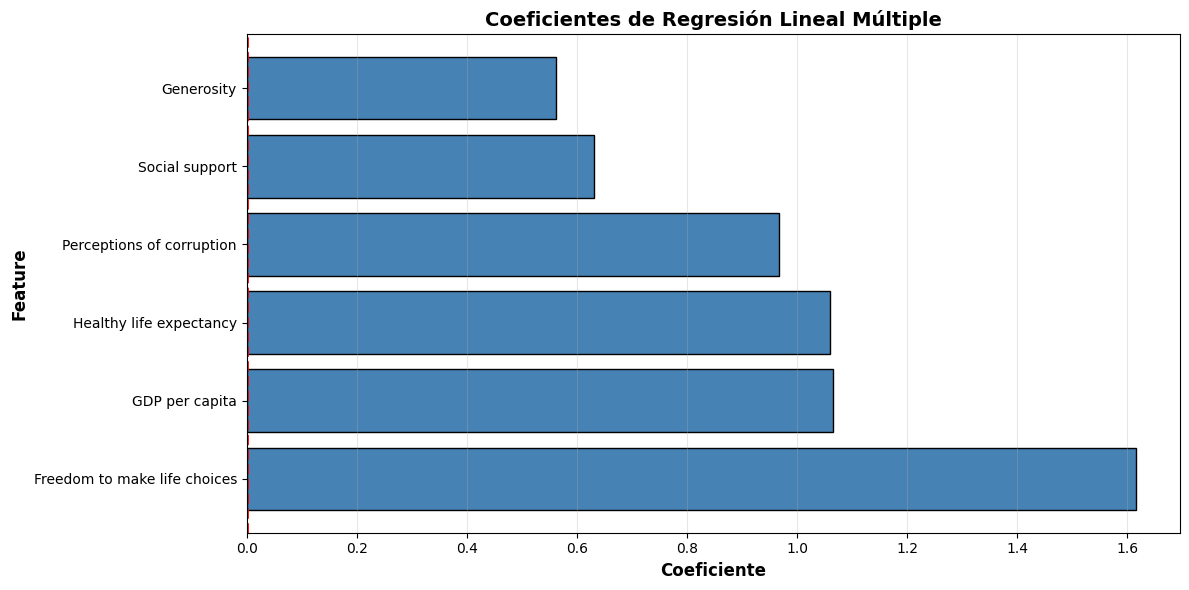

In [12]:
# Ver coeficientes del modelo
print("\nCOEFICIENTES DEL MODELO:")
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coeficiente': modelo_lr.coef_
}).sort_values('Coeficiente', ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept (β₀): {modelo_lr.intercept_:.4f}")

# Visualizar coeficientes
plt.figure(figsize=(12, 6))
plt.barh(coef_df['Feature'], coef_df['Coeficiente'], color='steelblue', edgecolor='black')
plt.xlabel('Coeficiente', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Coeficientes de Regresión Lineal Múltiple', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

In [13]:
# Hacer predicciones
y_pred_train_lr = modelo_lr.predict(X_train)
y_pred_test_lr = modelo_lr.predict(X_test)

# Calcular métricas para conjunto de entrenamiento
print("RESULTADOS EN CONJUNTO DE ENTRENAMIENTO")
metricas_train_lr = calcular_metricas(y_train, y_pred_train_lr, "Regresión Lineal (Train)")

# Calcular métricas para conjunto de prueba
print("RESULTADOS EN CONJUNTO DE PRUEBA")
metricas_test_lr = calcular_metricas(y_test, y_pred_test_lr, "Regresión Lineal (Test)")

RESULTADOS EN CONJUNTO DE ENTRENAMIENTO

MÉTRICAS DE EVALUACIÓN - Regresión Lineal (Train)
R² (Coefficient of Determination):    0.7675
MAE (Mean Absolute Error):            0.4225
MSE (Mean Squared Error):             0.2968
RMSE (Root Mean Squared Error):       0.5448
MAPE (Mean Absolute Percentage Error): 8.37%
RESULTADOS EN CONJUNTO DE PRUEBA

MÉTRICAS DE EVALUACIÓN - Regresión Lineal (Test)
R² (Coefficient of Determination):    0.7519
MAE (Mean Absolute Error):            0.4321
MSE (Mean Squared Error):             0.3098
RMSE (Root Mean Squared Error):       0.5566
MAPE (Mean Absolute Percentage Error): 8.68%


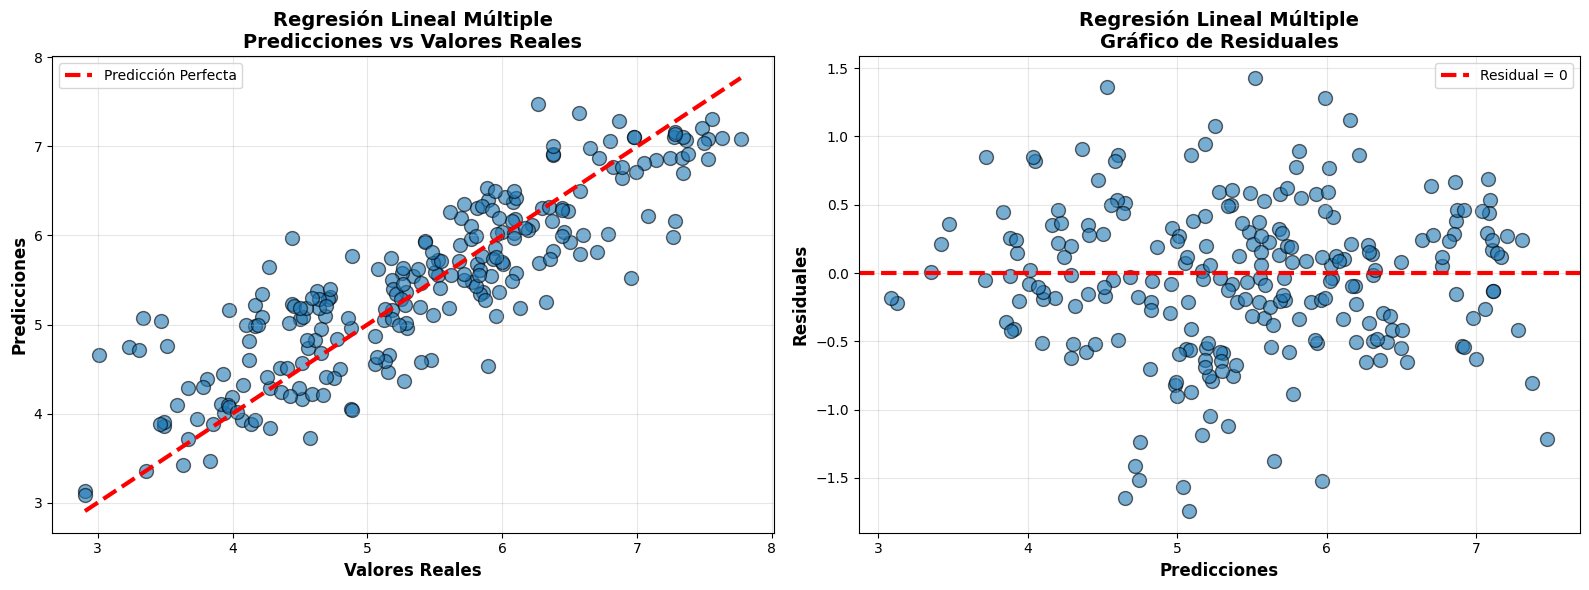

In [14]:
# Visualizar predicciones
graficar_predicciones(y_test, y_pred_test_lr, "Regresión Lineal Múltiple")

In [15]:
# Cross-Validation
cv_scores_lr = cross_val_score(modelo_lr, X, y, cv=5, scoring='r2')

print("\n" + "="*80)
print("VALIDACIÓN CRUZADA (5-FOLD)")
print("="*80)
print(f"\nR² scores por fold: {cv_scores_lr}")
print(f"R² promedio: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")


VALIDACIÓN CRUZADA (5-FOLD)

R² scores por fold: [0.74482507 0.62247672 0.76654563 0.78123223 0.75429586]
R² promedio: 0.7339 (+/- 0.1140)


---
## 🌲 4. Modelo: Random Forest Regressor

In [16]:
# Crear y entrenar Random Forest
modelo_rf = RandomForestRegressor(
    n_estimators=200,        # Número de árboles
    max_depth=15,            # Profundidad máxima
    min_samples_split=5,     # Mínimo de muestras para dividir
    min_samples_leaf=2,      # Mínimo de muestras en hoja
    random_state=42,
    n_jobs=-1                # Usar todos los cores
)

modelo_rf.fit(X_train, y_train)

print("\n✅ Modelo Random Forest entrenado exitosamente")
print(f"\nParámetros del modelo:")
print(f"  - Número de árboles: {modelo_rf.n_estimators}")
print(f"  - Profundidad máxima: {modelo_rf.max_depth}")
print(f"  - Min samples split: {modelo_rf.min_samples_split}")
print(f"  - Min samples leaf: {modelo_rf.min_samples_leaf}")


✅ Modelo Random Forest entrenado exitosamente

Parámetros del modelo:
  - Número de árboles: 200
  - Profundidad máxima: 15
  - Min samples split: 5
  - Min samples leaf: 2



IMPORTANCIA DE FEATURES (Random Forest):
                     Feature  Importancia
     Healthy life expectancy     0.379827
              GDP per capita     0.358615
Freedom to make life choices     0.110614
              Social support     0.067123
   Perceptions of corruption     0.042653
                  Generosity     0.041169


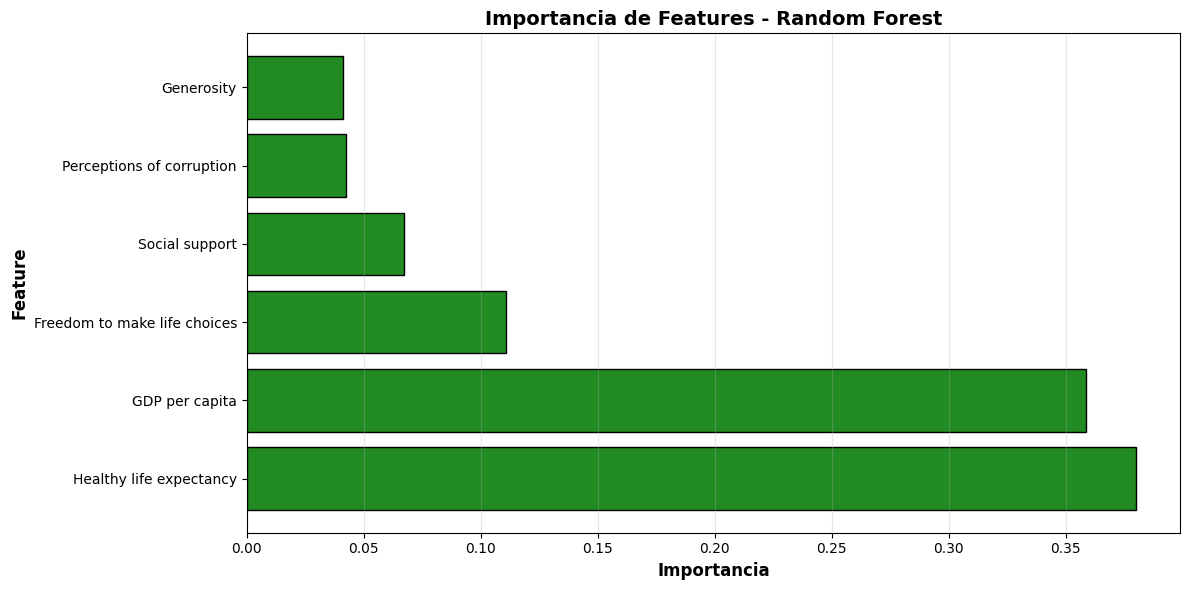

In [17]:
# Importancia de features en Random Forest
importancias_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nIMPORTANCIA DE FEATURES (Random Forest):")
print(importancias_rf.to_string(index=False))

# Visualizar importancias
plt.figure(figsize=(12, 6))
plt.barh(importancias_rf['Feature'], importancias_rf['Importancia'], 
         color='forestgreen', edgecolor='black')
plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Importancia de Features - Random Forest', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [18]:
# Hacer predicciones con Random Forest
y_pred_train_rf = modelo_rf.predict(X_train)
y_pred_test_rf = modelo_rf.predict(X_test)

# Calcular métricas para conjunto de entrenamiento
print("RESULTADOS EN CONJUNTO DE ENTRENAMIENTO")
metricas_train_rf = calcular_metricas(y_train, y_pred_train_rf, "Random Forest (Train)")

# Calcular métricas para conjunto de prueba
print("RESULTADOS EN CONJUNTO DE PRUEBA")
metricas_test_rf = calcular_metricas(y_test, y_pred_test_rf, "Random Forest (Test)")

RESULTADOS EN CONJUNTO DE ENTRENAMIENTO

MÉTRICAS DE EVALUACIÓN - Random Forest (Train)
R² (Coefficient of Determination):    0.9549
MAE (Mean Absolute Error):            0.1787
MSE (Mean Squared Error):             0.0576
RMSE (Root Mean Squared Error):       0.2401
MAPE (Mean Absolute Percentage Error): 3.55%
RESULTADOS EN CONJUNTO DE PRUEBA

MÉTRICAS DE EVALUACIÓN - Random Forest (Test)
R² (Coefficient of Determination):    0.8058
MAE (Mean Absolute Error):            0.3850
MSE (Mean Squared Error):             0.2426
RMSE (Root Mean Squared Error):       0.4925
MAPE (Mean Absolute Percentage Error): 7.76%


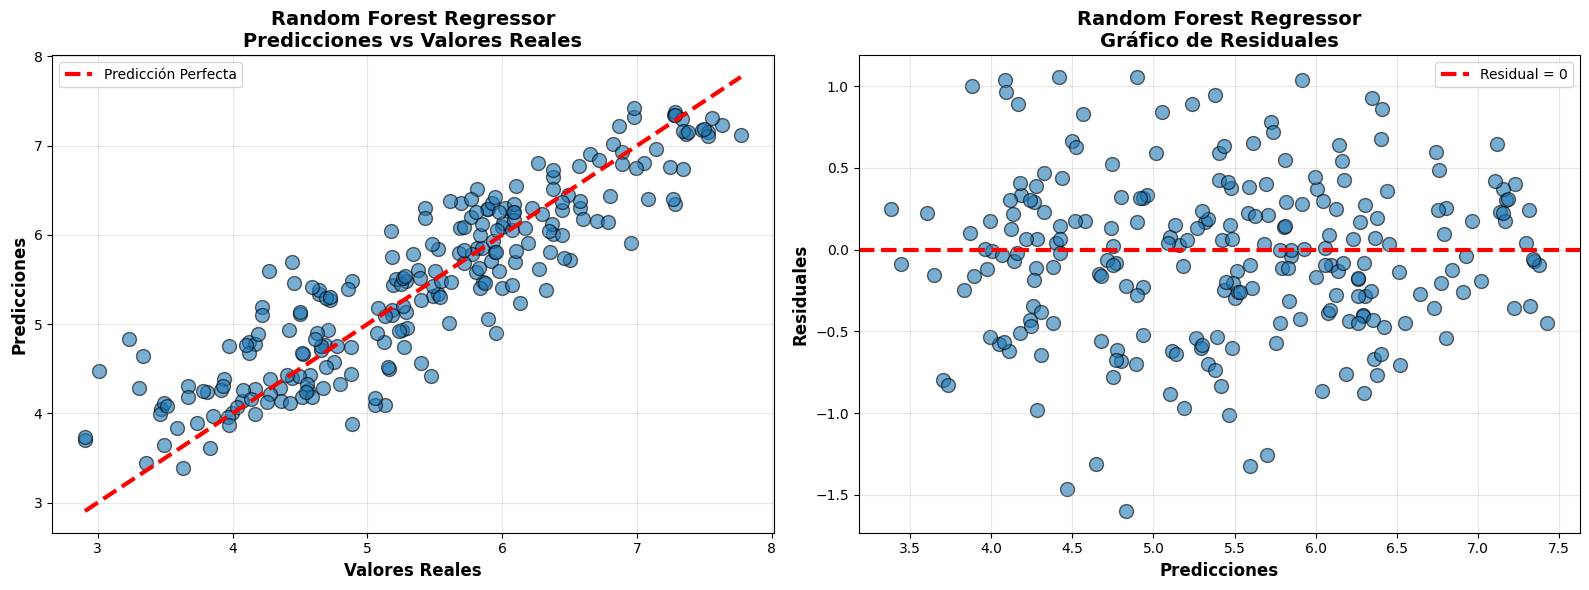

In [19]:
# Visualizar predicciones Random Forest
graficar_predicciones(y_test, y_pred_test_rf, "Random Forest Regressor")

In [20]:
# Cross-Validation Random Forest
cv_scores_rf = cross_val_score(modelo_rf, X, y, cv=5, scoring='r2')

print("\n" + "="*80)
print("VALIDACIÓN CRUZADA (5-FOLD) - Random Forest")
print("="*80)
print(f"\nR² scores por fold: {cv_scores_rf}")
print(f"R² promedio: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")


VALIDACIÓN CRUZADA (5-FOLD) - Random Forest

R² scores por fold: [0.77580226 0.70682996 0.84242388 0.8608509  0.70312542]
R² promedio: 0.7778 (+/- 0.1317)


---
## 🚀 5. Modelo: Regresión Lineal Múltiple con Escalado (StandardScaler)

In [21]:
# Crear StandardScaler
scaler = StandardScaler()

# Escalar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos escalados con StandardScaler")
print(f"\nMedia de X_train_scaled (debe ser ~0):")
print(X_train_scaled.mean(axis=0))
print(f"\nDesviación estándar de X_train_scaled (debe ser ~1):")
print(X_train_scaled.std(axis=0))

# Crear y entrenar modelo de Regresión Lineal con datos escalados
modelo_lr_scaled = LinearRegression()
modelo_lr_scaled.fit(X_train_scaled, y_train)

print("\n✅ Modelo de Regresión Lineal con Escalado entrenado exitosamente")
print(f"\nIntercept (β₀): {modelo_lr_scaled.intercept_:.4f}")

✅ Datos escalados con StandardScaler

Media de X_train_scaled (debe ser ~0):
[-3.90408097e-17 -4.50596011e-16 -1.13869028e-16  1.62670040e-18
 -2.47258461e-16 -1.07362227e-16]

Desviación estándar de X_train_scaled (debe ser ~1):
[1. 1. 1. 1. 1. 1.]

✅ Modelo de Regresión Lineal con Escalado entrenado exitosamente

Intercept (β₀): 5.3665



COEFICIENTES DEL MODELO ESCALADO:
                     Feature  Coeficiente
              GDP per capita     0.431370
     Healthy life expectancy     0.267236
Freedom to make life choices     0.248619
              Social support     0.210277
   Perceptions of corruption     0.099194
                  Generosity     0.067718

Intercept (β₀): 5.3665

💡 NOTA: Con datos escalados, los coeficientes son comparables directamente
   Un coeficiente mayor (en valor absoluto) indica mayor impacto en la predicción


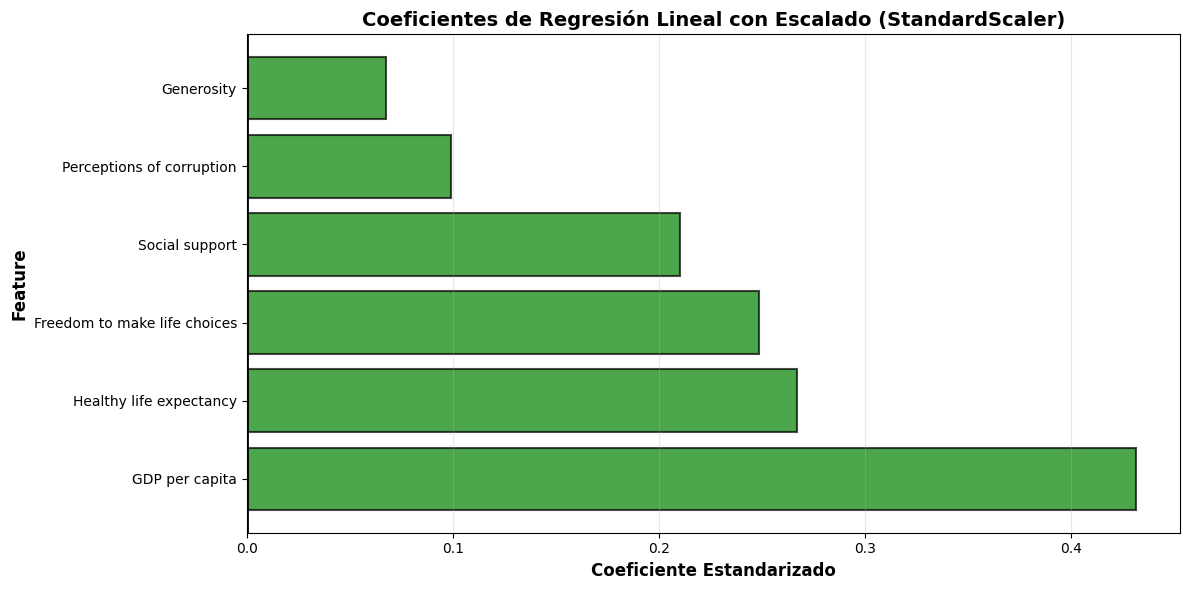

In [22]:
# Ver coeficientes del modelo escalado
print("\nCOEFICIENTES DEL MODELO ESCALADO:")
coef_scaled_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coeficiente': modelo_lr_scaled.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print(coef_scaled_df.to_string(index=False))
print(f"\nIntercept (β₀): {modelo_lr_scaled.intercept_:.4f}")

print("\n💡 NOTA: Con datos escalados, los coeficientes son comparables directamente")
print("   Un coeficiente mayor (en valor absoluto) indica mayor impacto en la predicción")

# Visualizar coeficientes
plt.figure(figsize=(12, 6))
colors = ['green' if c > 0 else 'red' for c in coef_scaled_df['Coeficiente']]
plt.barh(coef_scaled_df['Feature'], coef_scaled_df['Coeficiente'], 
         color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)
plt.xlabel('Coeficiente Estandarizado', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Coeficientes de Regresión Lineal con Escalado (StandardScaler)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.tight_layout()
plt.show()

In [23]:
# Hacer predicciones con Regresión Lineal Escalada
y_pred_train_lr_scaled = modelo_lr_scaled.predict(X_train_scaled)
y_pred_test_lr_scaled = modelo_lr_scaled.predict(X_test_scaled)

# Calcular métricas para conjunto de entrenamiento
print("RESULTADOS EN CONJUNTO DE ENTRENAMIENTO")
metricas_train_lr_scaled = calcular_metricas(y_train, y_pred_train_lr_scaled, "Regresión Lineal Escalada (Train)")

# Calcular métricas para conjunto de prueba
print("RESULTADOS EN CONJUNTO DE PRUEBA")
metricas_test_lr_scaled = calcular_metricas(y_test, y_pred_test_lr_scaled, "Regresión Lineal Escalada (Test)")

# Comparar con Regresión Lineal sin escalar
print("\n" + "="*80)
print("COMPARACIÓN: REGRESIÓN LINEAL vs REGRESIÓN LINEAL ESCALADA")
print("="*80)
print(f"\nR² (sin escalar):  {metricas_test_lr['R2']:.4f}")
print(f"R² (con escalar):  {metricas_test_lr_scaled['R2']:.4f}")
print(f"Diferencia:        {abs(metricas_test_lr['R2'] - metricas_test_lr_scaled['R2']):.6f}")
print("\n💡 NOTA: Para Regresión Lineal, el escalado NO cambia el R² ni las predicciones")
print("   Solo hace que los coeficientes sean más interpretables y comparables")

RESULTADOS EN CONJUNTO DE ENTRENAMIENTO

MÉTRICAS DE EVALUACIÓN - Regresión Lineal Escalada (Train)
R² (Coefficient of Determination):    0.7675
MAE (Mean Absolute Error):            0.4225
MSE (Mean Squared Error):             0.2968
RMSE (Root Mean Squared Error):       0.5448
MAPE (Mean Absolute Percentage Error): 8.37%
RESULTADOS EN CONJUNTO DE PRUEBA

MÉTRICAS DE EVALUACIÓN - Regresión Lineal Escalada (Test)
R² (Coefficient of Determination):    0.7519
MAE (Mean Absolute Error):            0.4321
MSE (Mean Squared Error):             0.3098
RMSE (Root Mean Squared Error):       0.5566
MAPE (Mean Absolute Percentage Error): 8.68%

COMPARACIÓN: REGRESIÓN LINEAL vs REGRESIÓN LINEAL ESCALADA

R² (sin escalar):  0.7519
R² (con escalar):  0.7519
Diferencia:        0.000000

💡 NOTA: Para Regresión Lineal, el escalado NO cambia el R² ni las predicciones
   Solo hace que los coeficientes sean más interpretables y comparables


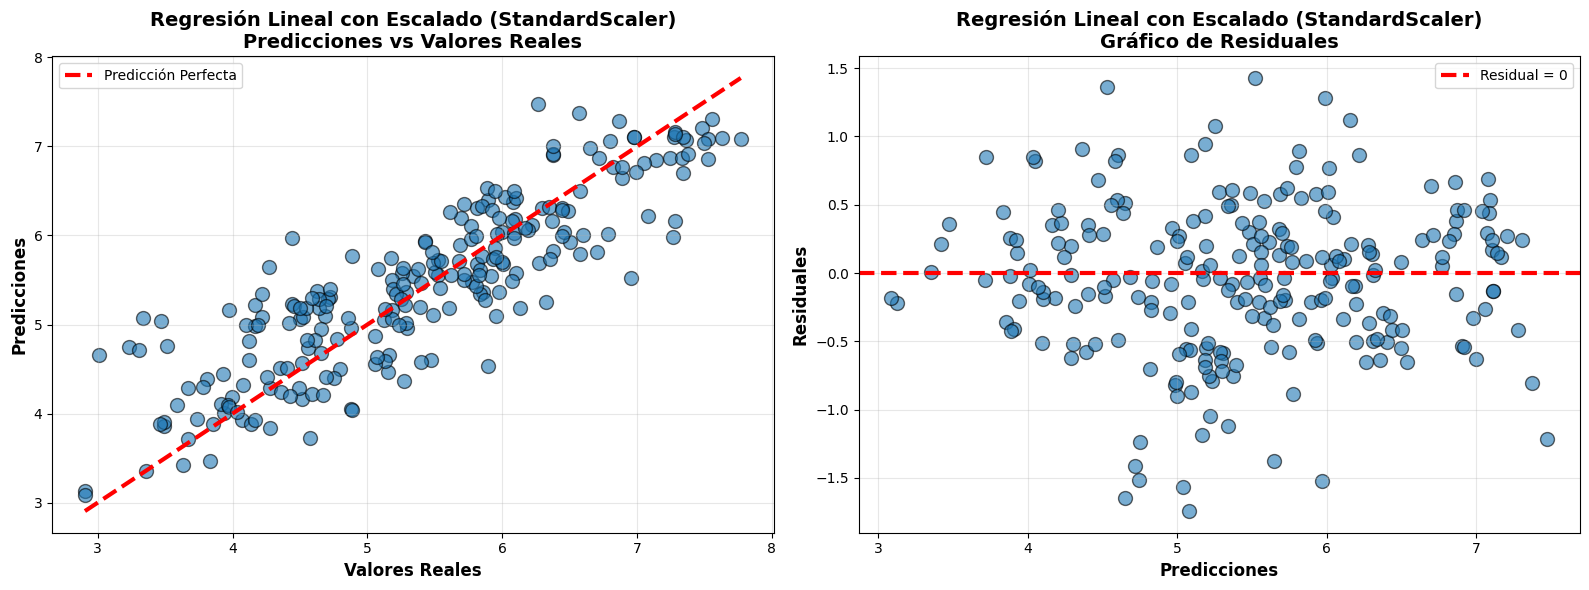

In [24]:
# Visualizar predicciones Regresión Lineal Escalada
graficar_predicciones(y_test, y_pred_test_lr_scaled, "Regresión Lineal con Escalado (StandardScaler)")

In [25]:
# Cross-Validation Regresión Lineal Escalada
# Crear pipeline para CV (scaler + modelo)
from sklearn.pipeline import Pipeline

pipeline_lr_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

cv_scores_lr_scaled = cross_val_score(pipeline_lr_scaled, X, y, cv=5, scoring='r2')

print("\n" + "="*80)
print("VALIDACIÓN CRUZADA (5-FOLD) - Regresión Lineal Escalada")
print("="*80)
print(f"\nR² scores por fold: {cv_scores_lr_scaled}")
print(f"R² promedio: {cv_scores_lr_scaled.mean():.4f} (+/- {cv_scores_lr_scaled.std() * 2:.4f})")

print("\n" + "="*80)
print("COMPARACIÓN VALIDACIÓN CRUZADA")
print("="*80)
print(f"\nRegresión Lineal (sin escalar):  {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")
print(f"Regresión Lineal (con escalar):  {cv_scores_lr_scaled.mean():.4f} (+/- {cv_scores_lr_scaled.std() * 2:.4f})")
print("\n💡 Los resultados son idénticos (el escalado no afecta las predicciones en LR)")


VALIDACIÓN CRUZADA (5-FOLD) - Regresión Lineal Escalada

R² scores por fold: [0.74482507 0.62247672 0.76654563 0.78123223 0.75429586]
R² promedio: 0.7339 (+/- 0.1140)

COMPARACIÓN VALIDACIÓN CRUZADA

Regresión Lineal (sin escalar):  0.7339 (+/- 0.1140)
Regresión Lineal (con escalar):  0.7339 (+/- 0.1140)

💡 Los resultados son idénticos (el escalado no afecta las predicciones en LR)


---
## 📊 6. Comparación de Modelos

In [26]:
# Comparación de los 3 modelos

comparacion_df = pd.DataFrame({
    'Modelo': ['Linear Regression', 'Linear Regression', 'Random Forest', 'Random Forest', 
               'Linear Regression Escalada', 'Linear Regression Escalada'],
    'Conjunto': ['Entrenamiento', 'Prueba', 'Entrenamiento', 'Prueba', 'Entrenamiento', 'Prueba'],
    'R²': [metricas_train_lr['R2'], metricas_test_lr['R2'],
           metricas_train_rf['R2'], metricas_test_rf['R2'],
           metricas_train_lr_scaled['R2'], metricas_test_lr_scaled['R2']],
    'MAE': [metricas_train_lr['MAE'], metricas_test_lr['MAE'],
            metricas_train_rf['MAE'], metricas_test_rf['MAE'],
            metricas_train_lr_scaled['MAE'], metricas_test_lr_scaled['MAE']],
    'RMSE': [metricas_train_lr['RMSE'], metricas_test_lr['RMSE'],
             metricas_train_rf['RMSE'], metricas_test_rf['RMSE'],
             metricas_train_lr_scaled['RMSE'], metricas_test_lr_scaled['RMSE']],
    'MAPE (%)': [metricas_train_lr['MAPE'], metricas_test_lr['MAPE'],
                 metricas_train_rf['MAPE'], metricas_test_rf['MAPE'],
                 metricas_train_lr_scaled['MAPE'], metricas_test_lr_scaled['MAPE']]
})

print("\n" + "="*100)
print("COMPARACIÓN DE MODELOS")
print("="*100)
print(comparacion_df.to_string(index=False))

# Resumen solo conjunto de prueba
print("\n" + "="*100)
print("RESUMEN - CONJUNTO DE PRUEBA")
print("="*100)
prueba_df = comparacion_df[comparacion_df['Conjunto'] == 'Prueba'][['Modelo', 'R²', 'MAE', 'RMSE', 'MAPE (%)']]
print(prueba_df.to_string(index=False))

# Identificar mejor modelo
mejor_r2 = prueba_df.loc[prueba_df['R²'].idxmax(), 'Modelo']
mejor_mae = prueba_df.loc[prueba_df['MAE'].idxmin(), 'Modelo']
mejor_rmse = prueba_df.loc[prueba_df['RMSE'].idxmin(), 'Modelo']

print(f"\n🏆 Mejor R² Score: {mejor_r2}")
print(f"🏆 Menor MAE: {mejor_mae}")
print(f"🏆 Menor RMSE: {mejor_rmse}")


COMPARACIÓN DE MODELOS
                    Modelo      Conjunto       R²      MAE     RMSE  MAPE (%)
         Linear Regression Entrenamiento 0.767534 0.422507 0.544822  8.374944
         Linear Regression        Prueba 0.751880 0.432146 0.556619  8.678414
             Random Forest Entrenamiento 0.954869 0.178708 0.240056  3.550112
             Random Forest        Prueba 0.805756 0.384955 0.492495  7.764971
Linear Regression Escalada Entrenamiento 0.767534 0.422507 0.544822  8.374944
Linear Regression Escalada        Prueba 0.751880 0.432146 0.556619  8.678414

RESUMEN - CONJUNTO DE PRUEBA
                    Modelo       R²      MAE     RMSE  MAPE (%)
         Linear Regression 0.751880 0.432146 0.556619  8.678414
             Random Forest 0.805756 0.384955 0.492495  7.764971
Linear Regression Escalada 0.751880 0.432146 0.556619  8.678414

🏆 Mejor R² Score: Random Forest
🏆 Menor MAE: Random Forest
🏆 Menor RMSE: Random Forest


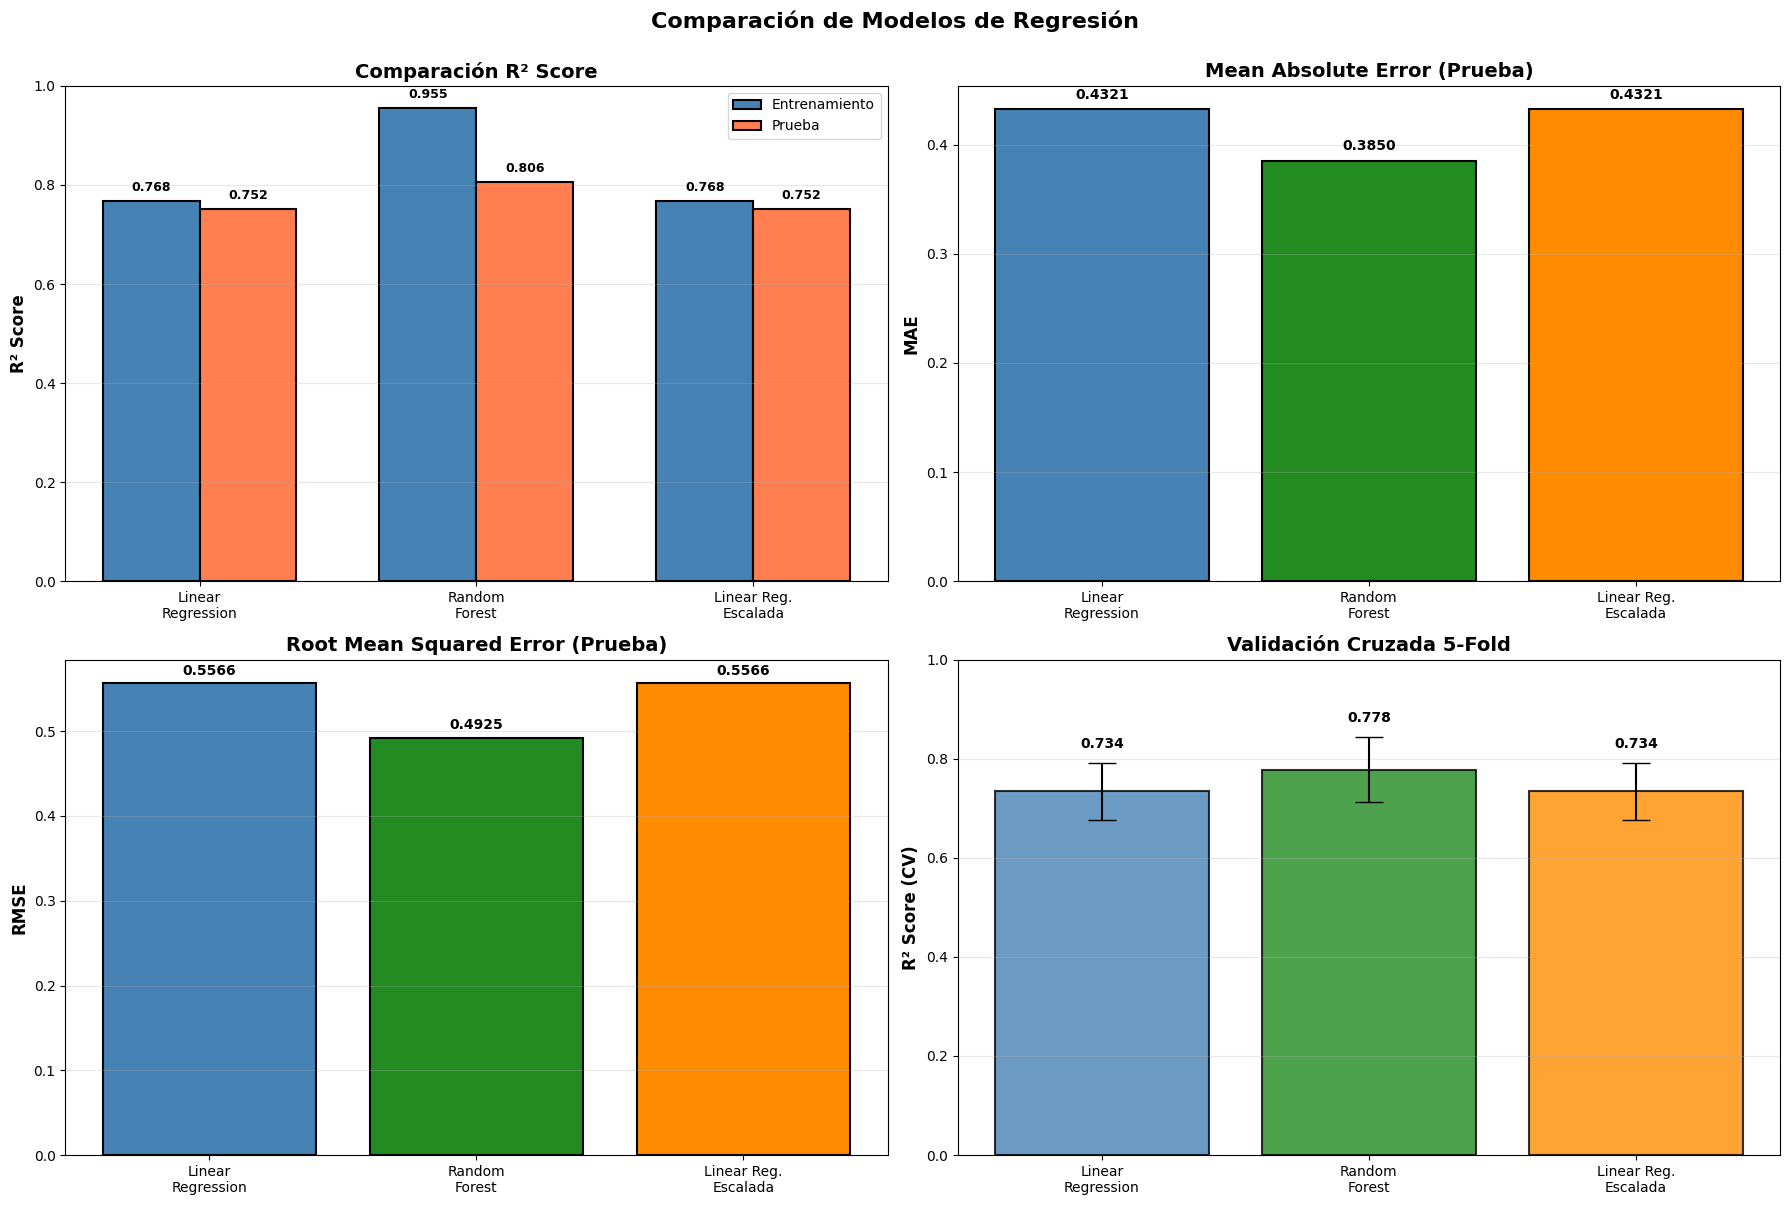

In [27]:
# Visualización comparativa de los 3 modelos
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Preparar datos para gráficos
modelos = ['Linear\nRegression', 'Random\nForest', 'Linear Reg.\nEscalada']
r2_train = [metricas_train_lr['R2'], metricas_train_rf['R2'], metricas_train_lr_scaled['R2']]
r2_test = [metricas_test_lr['R2'], metricas_test_rf['R2'], metricas_test_lr_scaled['R2']]
mae_test = [metricas_test_lr['MAE'], metricas_test_rf['MAE'], metricas_test_lr_scaled['MAE']]
rmse_test = [metricas_test_lr['RMSE'], metricas_test_rf['RMSE'], metricas_test_lr_scaled['RMSE']]

# Gráfico 1: R² Score (Train vs Test)
x = np.arange(len(modelos))
width = 0.35
axes[0, 0].bar(x - width/2, r2_train, width, label='Entrenamiento', 
               color='steelblue', edgecolor='black', linewidth=1.5)
axes[0, 0].bar(x + width/2, r2_test, width, label='Prueba', 
               color='coral', edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Comparación R² Score', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(modelos)
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, (v1, v2) in enumerate(zip(r2_train, r2_test)):
    axes[0, 0].text(i - width/2, v1 + 0.02, f'{v1:.3f}', ha='center', fontweight='bold', fontsize=9)
    axes[0, 0].text(i + width/2, v2 + 0.02, f'{v2:.3f}', ha='center', fontweight='bold', fontsize=9)

# Gráfico 2: MAE
colors = ['steelblue', 'forestgreen', 'darkorange']
axes[0, 1].bar(modelos, mae_test, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Mean Absolute Error (Prueba)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_test):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

# Gráfico 3: RMSE
axes[1, 0].bar(modelos, rmse_test, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Root Mean Squared Error (Prueba)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_test):
    axes[1, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

# Gráfico 4: Validación Cruzada
cv_means = [cv_scores_lr.mean(), cv_scores_rf.mean(), cv_scores_lr_scaled.mean()]
cv_stds = [cv_scores_lr.std(), cv_scores_rf.std(), cv_scores_lr_scaled.std()]
axes[1, 1].bar(modelos, cv_means, yerr=cv_stds, capsize=10, 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1, 1].set_ylabel('R² Score (CV)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Validación Cruzada 5-Fold', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, (v, std) in enumerate(zip(cv_means, cv_stds)):
    axes[1, 1].text(i, v + std + 0.03, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.suptitle('Comparación de Modelos de Regresión', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()